## Note:

Due to intrinsic stochasticity in the underlying algorithms, results may differ slightly between runs.

If errors arise in preparation of survival data (e.g., miner.kmAnalysis), consider downgrading scipy in accordance with the lifelines package.

## Import libraries

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import random as rd
import os
import json
from sklearn.decomposition import PCA
import multiprocessing, multiprocessing.pool
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
from sklearn.manifold import TSNE
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn import tree
import miner_py3 as miner
%matplotlib inline
plt.style.use('ggplot')

## Create directory to save output files

In [4]:
# Path to the miner directory
input_path = os.path.join(os.path.expanduser('~'),'Desktop','miner3-master','miner')

# create name for results folder where output files will be saved
resultsFolder = "results_miner"

# name of the folder containing the miner network
#networkFolder = "miner_network_results"
networkFolder = "results_minCorrelation_0o2_50_allFiles"

# create results directory
resultsDirectory = os.path.join(os.path.split(os.getcwd())[0],resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

## Load primary data

In [5]:
# Load expression Data
expressionFile = os.path.join(input_path,"data","expression","IA12Zscore.csv")
#expressionData = pd.read_csv(expressionFile,index_col=0,header=0)
expressionData, conversionTable = miner.preprocess(expressionFile)

# Load mutations
common_mutations = pd.read_csv(os.path.join(input_path,'data','mutations','commonMutations.csv'),index_col=0,header=0)
translocations = pd.read_csv(os.path.join(input_path,'data','mutations','translocationsIA12.csv'),index_col=0,header=0)
cytogenetics = pd.read_csv(os.path.join(input_path,'data','mutations','cytogenetics.csv'),index_col=0,header=0)
cytogenetics = cytogenetics.loc[:,list(set(cytogenetics.columns)&set(expressionData.columns))]
common_patients_mutations_translocations = list(set(translocations.columns)&set(common_mutations.columns))
mutation_matrix = pd.concat([common_mutations.loc[:,common_patients_mutations_translocations],translocations.loc[:,common_patients_mutations_translocations]],axis=0)

#If previous results exist, use miner.read_json to load them
revisedClusters = miner.read_json(os.path.join(input_path,networkFolder,"coexpressionDictionary.json"))
coexpressionModules = miner.read_json(os.path.join(input_path,networkFolder,"coexpressionModules.json"))
regulonModules = miner.read_json(os.path.join(input_path,networkFolder,"regulons.json"))
mechanisticOutput = miner.read_json(os.path.join(input_path,networkFolder,"mechanisticOutput.json"))
regulonDf = pd.read_csv(os.path.join(input_path,networkFolder,"regulonDf.csv"),index_col=0,header=0)
overExpressedMembersMatrix = pd.read_csv(os.path.join(input_path,networkFolder,"overExpressedMembers.csv"),index_col=0,header=0)
overExpressedMembersMatrix.index = np.array(overExpressedMembersMatrix.index).astype(str)
underExpressedMembersMatrix = pd.read_csv(os.path.join(input_path,networkFolder,"underExpressedMembers.csv"),index_col=0,header=0)
underExpressedMembersMatrix.index = np.array(underExpressedMembersMatrix.index).astype(str)
eigengenes = pd.read_csv(os.path.join(input_path,networkFolder,"eigengenes.csv"),index_col=0,header=0)
eigengenes.index = np.array(underExpressedMembersMatrix.index).astype(str)

completed identifier conversion.
16216 genes were converted.


## Load network

In [6]:
# Load transcriptional programs
transcriptional_programs = miner.read_json(os.path.join(input_path,networkFolder,'transcriptional_programs.json'))
program_list = [transcriptional_programs[str(key)] for key in range(len(transcriptional_programs.keys()))]

In [7]:
# Load transcriptional states
transcriptional_states = miner.read_json(os.path.join(input_path,networkFolder,'transcriptional_states.json'))
states_list = [transcriptional_states[str(key)] for key in range(len(transcriptional_states.keys()))]
final_state = list(set(expressionData.columns)-set(np.hstack(states_list)))
if len(final_state)>0:
    states_list.append(final_state)
states = states_list.copy()
diff_matrix_MMRF = overExpressedMembersMatrix-underExpressedMembersMatrix

In [8]:
trn = pd.read_csv(os.path.join(input_path,networkFolder,"filteredCausalResults.csv"),index_col=0,header=0)

## Load primary survival data

In [9]:
# load primary survival data (i.e., corresponding to expression data training set)
survivalMMRF = pd.read_csv(os.path.join(input_path,"data","survival","survivalIA12.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
kmDfMMRF = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
guanSurvivalDfMMRF= miner.guanRank(kmSurvival=kmDfMMRF)

## Infer nework-constrained gene activity

In [10]:
network_activity_overexpressed = miner.networkActivity(regulon_matrix=regulonDf.copy(),
                                                 reference_matrix=overExpressedMembersMatrix.copy(),
                                                 minRegulons = 2)
network_activity_underexpressed = miner.networkActivity(regulon_matrix=regulonDf.copy(),
                                                 reference_matrix=underExpressedMembersMatrix.copy(),
                                                 minRegulons = 2)
network_activity_diff = miner.networkActivity(regulon_matrix=regulonDf.copy(),
                                                 reference_matrix=diff_matrix_MMRF.copy(),
                                                 minRegulons = 2)

In [11]:
baseline_patients = [name for name in network_activity_diff.columns if name.split("_")[2]=="1"]

In [12]:
relapse_patients = [name for name in network_activity_diff.columns if name.split("_")[2]=="2"]

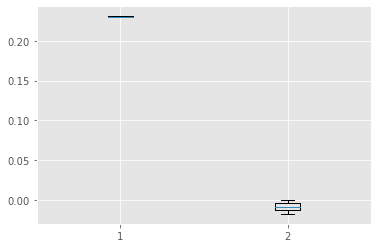

In [13]:
crbn = "ENSG00000113851"
ikzf1 = "ENSG00000185811"
ikzf3 = "ENSG00000161405"
nr3c1 = "ENSG00000113580"
psmb5 = "ENSG00000100804"

df = diff_matrix_MMRF.copy()
regs = np.array(regulonDf[regulonDf.Gene==crbn]["Regulon_ID"]).astype(str)

baseline = []
relapse = []
for reg in regs:
    mean_baseline = np.mean(df.loc[reg,baseline_patients])
    mean_relapse = np.mean(df.loc[reg,relapse_patients])
    baseline.append(mean_baseline)
    relapse.append(mean_relapse)

_=plt.boxplot([baseline,relapse])

## Compare expression and network activity of drug targets

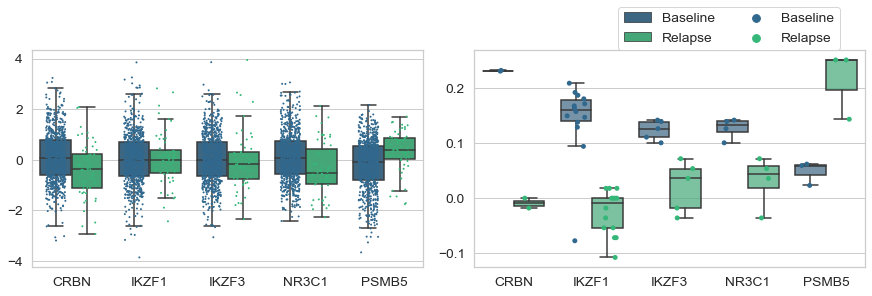

In [14]:
reg_df = diff_matrix_MMRF.copy()
act_df = network_activity_diff.copy()
df = expressionData.copy()

targets = [
    crbn,
    ikzf1,
    ikzf3,
    nr3c1,
    psmb5
]

target_names = [
    "CRBN",
    "IKZF1",
    "IKZF3",
    "NR3C1",
    "PSMB5"
]

###########################################
reg_gene = []
reg_timepoint = []
reg_baseline = []
for i in range(len(target_names)):
    name = target_names[i]
    target = targets[i]
    regs = np.array(regulonDf[regulonDf.Gene==target]["Regulon_ID"]).astype(str)
    for reg in regs:
        mean_baseline = np.mean(reg_df.loc[reg,baseline_patients])
        reg_baseline.append(mean_baseline)
        reg_gene.append(name)
        reg_timepoint.append("Baseline")
        mean_relapse = np.mean(reg_df.loc[reg,relapse_patients])
        reg_gene.append(name)
        reg_timepoint.append("Relapse")
        reg_baseline.append(mean_relapse)

reg_data = pd.DataFrame(np.vstack([reg_gene,
                       reg_timepoint,
                       reg_baseline]).T)
reg_data.columns = ["Target","Timepoint","Mean Regulon Activity"]
reg_data["Mean Regulon Activity"] = pd.to_numeric(reg_data["Mean Regulon Activity"])

###########################################
gene = []
timepoint = []
baseline = []
relapse = []
for i in range(len(targets)):
    target = targets[i]
    baseline.extend(np.array(act_df.loc[target,baseline_patients]).astype(float))
    for iteration in range(len(baseline_patients)):
        gene.append(target_names[i])
        timepoint.append("Baseline")
    baseline.extend(np.array(act_df.loc[target,relapse_patients]).astype(float))
    for iteration in range(len(relapse_patients)):
        gene.append(target_names[i])
        timepoint.append("Relapse")
        
act_data = pd.DataFrame(np.vstack([gene,
                       timepoint,
                       baseline]).T)
act_data.columns = ["Target","Timepoint","Activity"]
act_data["Activity"] = pd.to_numeric(act_data["Activity"])

###################################

exp_gene = []
exp_timepoint = []
exp_baseline = []
exp_relapse = []
for i in range(len(targets)):
    target = targets[i]
    exp_baseline.extend(np.array(df.loc[target,baseline_patients]).astype(float))
    for iteration in range(len(baseline_patients)):
        exp_gene.append(target_names[i])
        exp_timepoint.append("Baseline")
    exp_baseline.extend(np.array(df.loc[target,relapse_patients]).astype(float))
    for iteration in range(len(relapse_patients)):
        exp_gene.append(target_names[i])
        exp_timepoint.append("Relapse")
        
exp_data = pd.DataFrame(np.vstack([exp_gene,
                       exp_timepoint,
                       exp_baseline]).T)
exp_data.columns = ["Target","Timepoint","Expression"]
exp_data["Expression"] = pd.to_numeric(exp_data["Expression"])

######################################
fig = plt.figure(constrained_layout=True,figsize=(12,4))
sns.set(style="whitegrid",font_scale = 1.25)

# Set figure axes
n_rows = 1
n_cols = 2
gs = fig.add_gridspec(n_rows, n_cols)

# Fill first subplot
fig.add_subplot(gs[0,0])
#sns.stripplot(data=exp_data, x='Target', y='Expression',hue="Timepoint",
#                      dodge=True,jitter=0.25,size=3,palette="viridis")

ax = sns.stripplot(data=exp_data, x='Target', y='Expression',hue="Timepoint",
                      dodge=True,jitter=0.25,size=2,palette='viridis')
ax = sns.boxplot(data=exp_data, x='Target', y='Expression',hue="Timepoint",
                  dodge=True,fliersize=0,palette="viridis")
# # Add transparency to colors
# for patch in ax.artists:
#     r, g, b, a = patch.get_facecolor()
#     patch.set_facecolor((r, g, b, 0.7))
    
ax.legend_.remove()
ax.set_ylabel("\n")
ax.set_xlabel("")

#ax.set_xlabel("")
# Fill second subplot
fig.add_subplot(gs[0,1])
ax = sns.boxplot(data=reg_data, x='Target', y='Mean Regulon Activity',hue="Timepoint",
                  dodge=True,fliersize=0,palette="viridis")
# Add transparency to colors
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.7))
    
ax = sns.stripplot(data=reg_data, x='Target', y='Mean Regulon Activity',hue="Timepoint",
                      dodge=True,jitter=0.25,size=5,palette='viridis')


        
ax.set_ylabel("\n")
ax.set_xlabel("")
ax.legend(loc='center left', bbox_to_anchor=(0.35, 1.1), ncol=2)
plt.savefig(os.path.join(resultsDirectory,"relapse_boxplots.pdf"))

In [15]:
df = expressionData.copy()
targets = [
    crbn,
    ikzf1,
    ikzf3,
    nr3c1,
    psmb5
]

target_names = [
    "CRBN",
    "IKZF1",
    "IKZF3",
    "NR3C1",
    "PSMB5"
]


In [16]:
#Load table for converting gene names
id_table_path = os.path.join(os.path.expanduser("~"),"Desktop","GitHub","miner","miner","data","identifier_mappings.txt")
id_table = pd.read_csv(id_table_path,sep="\t")
id_table = id_table[id_table["Source"] == "Gene Name"]
id_table.index = id_table.iloc[:,0]

targets = list(act_df.index)
target_names = miner.gene_conversion(targets,id_table=id_table,list_symbols=True)

In [17]:
reg_df = diff_matrix_MMRF.copy()
act_df = network_activity_diff.copy()
df = expressionData.copy()

targets = list(act_df.index)
target_names = miner.gene_conversion(targets,id_table=id_table,list_symbols=True)

###########################################
reg_gene = []
baseline_score = []
relapse_score = []
w_stats = []
w_ps = []
for i in range(len(target_names)):
    name = target_names[i]
    target = targets[i]
    reg_gene.append(name)
    regs = np.array(regulonDf[regulonDf.Gene==target]["Regulon_ID"]).astype(str)
    reg_relapse = []
    reg_baseline = []
    for reg in regs:
        mean_baseline = np.mean(reg_df.loc[reg,baseline_patients])
        reg_baseline.append(mean_baseline)
        mean_relapse = np.mean(reg_df.loc[reg,relapse_patients])
        reg_relapse.append(mean_relapse)
    baseline_score.append(np.mean(reg_baseline))
    relapse_score.append(np.mean(reg_relapse))
    w, p = stats.ranksums(reg_baseline,reg_relapse)
    w_stats.append(w)
    w_ps.append(p)
    
results_reg_act = pd.DataFrame(np.vstack([reg_gene,baseline_score,relapse_score,w_stats,w_ps]).T)
results_reg_act.columns = ["Gene","Baseline","Relapse","Statistic","p"]
results_reg_act.head()

,Gene,Baseline,Relapse,Statistic,p
0,CRIPT,0.11630295250320924,0.23928571428571427,-2.6111648393354674,0.009023438818080326
1,PPIL1,0.09207608822499709,0.19642857142857142,-3.8414031302822718,0.00012233301318702674
2,METTL23,0.09916559691912709,0.1994047619047619,-3.8105117766515297,0.0001386794054294884
3,ZSCAN20,0.11938382541720154,0.20714285714285716,-1.775592090748118,0.07580017458236125
4,TMEM254,0.12291399229781771,0.19866071428571427,-1.995399119739914,0.045999366875037084


In [18]:
np.where(np.array(results_reg_act.iloc[:,4]).astype(float)<0.001)[0]

array([   1,    2,    9, ..., 5473, 5678, 5792])

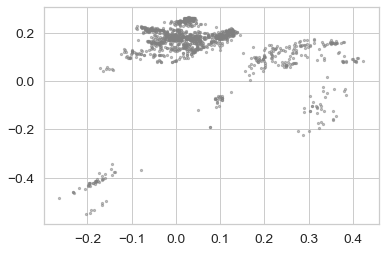

In [19]:
sig_filter = np.where(np.array(results_reg_act.iloc[:,4]).astype(float)<1e-3)[0]

plt.scatter(np.array(results_reg_act.iloc[sig_filter,2]).astype(float),
            np.array(results_reg_act.iloc[sig_filter,1]).astype(float),
            s=5,color="gray",alpha=0.5)

In [20]:
baseline_filter = np.where(np.array(results_reg_act.loc[:,"Baseline"]).astype(float)<0)[0]
relapse_filter = np.where(np.array(results_reg_act.loc[:,"Relapse"]).astype(float)>0.3)[0]
filter_intersection = miner.intersect(baseline_filter,relapse_filter)

sig_filter = np.where(np.array(results_reg_act.iloc[:,4]).astype(float)<1e-3)[0]
filter_intersection = miner.intersect(filter_intersection,sig_filter)
results_reg_act.iloc[filter_intersection,:]

,Gene,Baseline,Relapse,Statistic,p
1408,SERPINA1,-0.14562829838824703,0.3630952380952381,-3.5762373640756184,0.000348575174213053
1412,SELENBP1,-0.17372700042789901,0.3214285714285714,-3.5762373640756184,0.000348575174213053
1419,PLXND1,-0.16859221223791188,0.32738095238095233,-3.5762373640756184,0.000348575174213053
1420,TBC1D4,-0.1138822666422153,0.3290816326530613,-4.502872646318738,6.704106102318287e-06
2319,RASSF4,-0.06290115532734274,0.3022959183673469,-4.502872646318738,6.704106102318287e-06
2320,ZFHX3,-0.09604387909907808,0.3262987012987013,-3.9727331518303837,7.105263288600155e-05
2321,BLVRB,-0.023908857509627728,0.33370535714285715,-4.824181513244218,1.4057935180978473e-06
1426,LGMN,-0.20738838967337042,0.3015873015873016,-3.5762373640756184,0.000348575174213053
1427,SEPP1,-0.03225288831835687,0.3571428571428572,-3.3606722016672235,0.0007775304469403846
1428,SIRPB2,-0.15561260875766653,0.3551587301587302,-3.5762373640756184,0.000348575174213053


## Compare predictive power of individual features

In [21]:
# Define subtypes
subtypes = {"Del 17":miner.getMutations("del17",cytogenetics),
            "Amp 1q":miner.getMutations("amp1q",cytogenetics),
            "t(4;14)":miner.getMutations("RNASeq_WHSC1_Call",translocations),
            "t(14;16)":miner.getMutations("RNASeq_MAF_Call",translocations),
            "MYC":miner.getMutations("RNASeq_MYC_Call",translocations)}

# Define survival dataset
srv = guanSurvivalDfMMRF

# Number of bootstrap iterations to be performed
n_iter = 500

# Set thresholds for high- and low-risk groups
hr_prop = 0.30
lr_prop = 0.70

Iterating subtype Del 17
Iterating subtype Amp 1q
Iterating subtype t(4;14)
Iterating subtype t(14;16)
Iterating subtype MYC


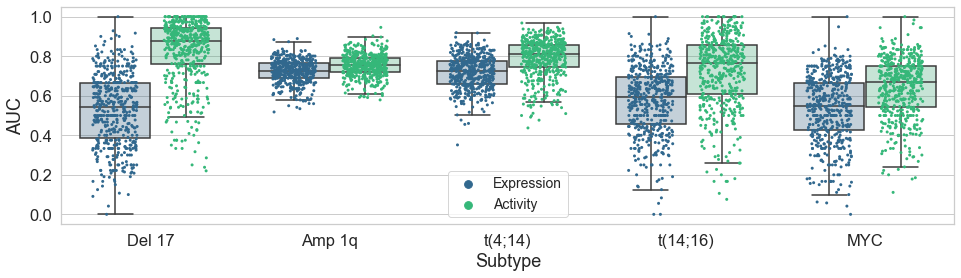

In [26]:
# Compare bootstrapped AUCs from predictions using 
# the expression vs. network activity of single genes
univariate_comparison_df, univ_data, univ_fig = miner.univariate_comparison(subtypes,srv,expressionData,network_activity_diff,
                                                                            n_iter = 500,hr_prop = 0.30,lr_prop = 0.70,
                                                                            results_directory = resultsDirectory)

## Stratify risk based upon univariate features

F1 score: 0.53
F1 score: 0.46
F1 score: 0.48
F1 score: 0.59
F1 score: 0.50


/Users/mwall/Desktop/miner3-master/miner/src/miner_py3.py:2436: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(-20, 120, 20))


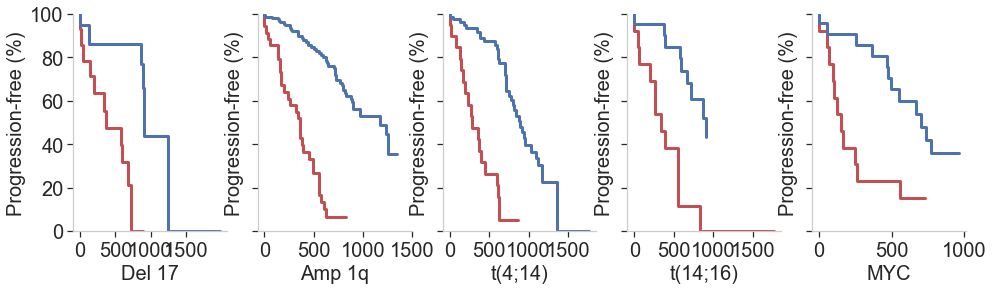

In [27]:
reload(miner)
# Optimize thresholds for network activity of predictive genes
optimized_survival_parameters = miner.optimize_survival_parameters(univ_data,
                                  network_activity_diff,subtypes,srv,abs_threshold=0.25)
 
# Plot subtype survival
survival_figure = miner.univariate_survival(subtypes,optimized_survival_parameters,network_activity_diff,srv,results_directory=resultsDirectory,font_scale=0.5)

## Infer states from network activity

In [78]:
# Infer transcriptional states
minClusterSize = int(np.ceil(0.01*expressionData.shape[1]))
referenceMatrix = network_activity_overexpressed-network_activity_underexpressed
primaryMatrix = network_activity_overexpressed
primaryDictionary = miner.matrix_to_dictionary(primaryMatrix,threshold=0.5)
secondaryMatrix = network_activity_underexpressed
secondaryDictionary = miner.matrix_to_dictionary(secondaryMatrix,threshold=0.5)

np.random.seed(12)
inferred_states, centroidClusters = miner.inferSubtypes(referenceMatrix,primaryMatrix,secondaryMatrix,primaryDictionary,secondaryDictionary,minClusterSize = int(np.ceil(0.01*primaryMatrix.shape[1])),restricted_index=None)
states_dictionary = {str(i):inferred_states[i] for i in range(len(inferred_states))}
print(len(inferred_states),len(np.hstack(inferred_states)))

Beginning subtype inference
completed subtype inference in 1.45 minutes
27 881


## Infer genetic programs from network activity

In [79]:
# Infer gene clusters
states = inferred_states.copy() #states_list.copy()
dfr = network_activity_diff.copy()
minClusterSize_x = 9
minClusterSize_y = 6
max_groups = 50
allow_singletons = False
random_state = 12

# Cluster genes using original transcriptional states
gene_clusters, gene_groups = miner.cluster_features(dfr,states,minClusterSize_x,minClusterSize_y,
                    max_groups,allow_singletons,random_state)

Completed clustering in 4.48 minutes


## Integrate all plots into figure

In [85]:
reload(miner)

<module 'miner_py3' from '/Users/mwall/Desktop/miner3-master/miner/src/miner_py3.py'>

/Users/mwall/Desktop/miner3-master/miner/src/miner_py3.py:2617: UserWarning: FixedFormatter should only be used together with FixedLocator
  f3_ax00.set_yticklabels(list(range(-1,7)))
/Users/mwall/Desktop/miner3-master/miner/src/miner_py3.py:2629: UserWarning: FixedFormatter should only be used together with FixedLocator
  f3_ax01.set_ylabel("Genes (thousands)")
/Users/mwall/Desktop/miner3-master/miner/src/miner_py3.py:2708: UserWarning: FixedFormatter should only be used together with FixedLocator
  if s==0:
/Users/mwall/Desktop/miner3-master/miner/src/miner_py3.py:2708: UserWarning: FixedFormatter should only be used together with FixedLocator
  if s==0:
/Users/mwall/Desktop/miner3-master/miner/src/miner_py3.py:2708: UserWarning: FixedFormatter should only be used together with FixedLocator
  if s==0:
/Users/mwall/Desktop/miner3-master/miner/src/miner_py3.py:2708: UserWarning: FixedFormatter should only be used together with FixedLocator
  if s==0:
/Users/mwall/Desktop/miner3-master/

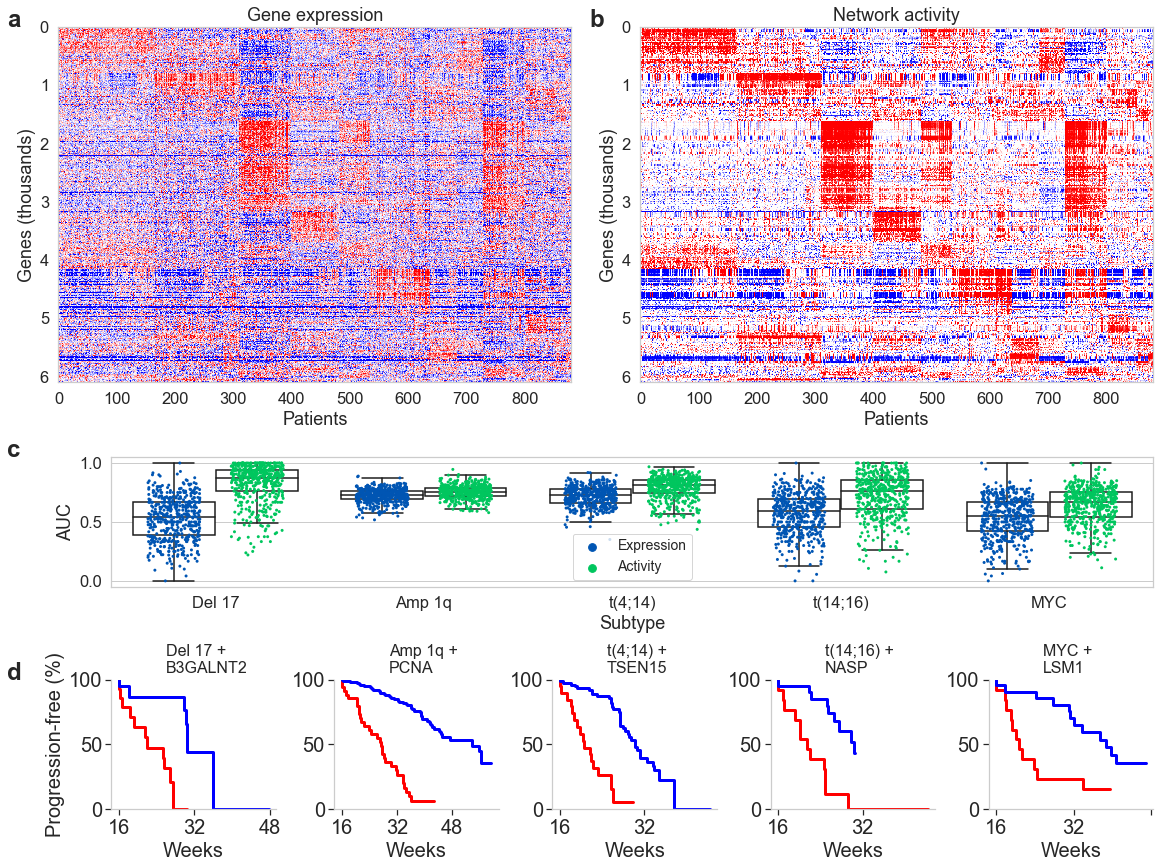

In [88]:
reload(miner)
#sns.set(font_scale=1.5,style="whitegrid")
gene_labels = miner.gene_conversion([optimized_survival_parameters[key]['gene'] for key in optimized_survival_parameters.keys()],
                      input_type="ensembl",output_type="symbol",list_symbols=True,id_table=id_table)
fig3, hr_groups, lr_groups = miner.composite_survival_figure(univariate_comparison_df,subtypes,
                             optimized_survival_parameters,network_activity_diff,
                             expressionData,srv,gene_clusters,inferred_states,
                             results_directory=resultsDirectory,gene_names = gene_labels)
plt.savefig(os.path.join(resultsDirectory,"composite_survival_figure.png"),dpi=400)



In [83]:
reload(miner)

<module 'miner_py3' from '/Users/mwall/Desktop/miner3-master/miner/src/miner_py3.py'>

## Survival plot of sub-stratified high-risk groups

<ipython-input-81-b34fc9b10d78>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(-20, 120, 20))


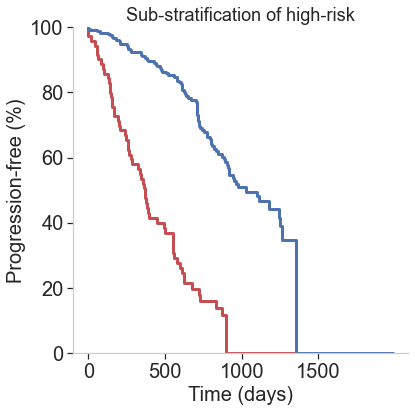

In [81]:
plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_ylim(-0.05,100.05)
ax.grid(color='w', linestyle='--', linewidth=1)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

timeline = list(srv.loc[np.hstack([hr_groups, lr_groups]),srv.columns[0]])
max_time = max(timeline)
ax.set_xticks(np.arange(0, max_time, 500))
ax.set_xlabel("Days")
ax.set_ylabel("Progression-free (%)")
ax.set_yticklabels(np.arange(-20, 120, 20))
ax.set_title("Sub-stratification of high-risk")

groups = [hr_groups,lr_groups]
miner.kmplot(srv,groups,labels = ["Activated","Inactivated"],
             xlim_=None,filename=None,color=["r","b"],lw=3,alpha=1,fs=20)



## Write network activity to file

In [ ]:
# Network activity
network_activity_diff.to_csv(os.path.join(resultsDirectory,"network_activity.csv"))

# Gene expression
expressionData.loc[network_activity_diff.index,:].to_csv(os.path.join(resultsDirectory,"gene_expression_mmrf.csv"))